## Preparing data

Loading the text from websites.  
Then splitting text into paragraphs

In [1]:
import requests
from bs4 import BeautifulSoup

def load_split_text(url):
    '''Load the text from the website, and split text into paragraphs'''
    raw_data = requests.get(url)
    assert raw_data.status_code == 200
    soup = BeautifulSoup(raw_data.text, 'html5lib')
    post = soup.find_all('div', {'class': 'lacontent'})[0]
    text = post.get_text()
    paragraphs = [paragraph for paragraph in text.split('\n') if len(paragraph)>0]
    return paragraphs

chapters = []
for i in range(595996,596116):
    url = 'http://www.guoxuemeng.com/guoxue/' + str(i) + '.html'
    chapters.append(load_split_text(url))

Named entity recognition using spacy.  
Extracting the characters of the novel.

In [2]:
import spacy
import re

NLP = spacy.load('en_core_web_sm')
name_re = re.compile(r"[A-Z][a-z]* [A-Z][a-z]*$")
name_re_genitive = re.compile(r"[A-Z][a-z]* [A-Z][a-z]*'s")

people_by_chapters = []
for chapter in chapters:
    people_by_paragraphs = []
    for paragraph in chapter:
        people_one_paragraph = []
        doc = NLP(paragraph)
        for ent in doc.ents:
            if str(ent.label_) == 'PERSON':
                if re.match(name_re, str(ent)):
                    people_one_paragraph.append(str(ent))
                elif re.match(name_re_genitive, str(ent)):
                    people_one_paragraph.append(str(ent)[:-2])
        if len(people_one_paragraph)>0:
            people_by_paragraphs.append(people_one_paragraph)
    people_by_chapters.append(people_by_paragraphs)

In [3]:
people_by_chapters[0]

[['Liu Bang', 'Wang Mang', 'Liu Xiu'],
 ['Emperor Huan',
  'Emperor Ling',
  'Chen Fan',
  'Dou Wu',
  'Chen Fan',
  'Dou Wu',
  'Chen Fan'],
 ['Emperor Ling'],
 ['Emperor Ling'],
 ['Cai Yong'],
 ['Cao Jie', 'Cai Yong'],
 ['Zhang Rang',
  'Zhao Zhong',
  'Cheng Kuang',
  'Duan Gui',
  'Feng Xu',
  'Guo Sheng',
  'Hou Lan',
  'Jian Shuo',
  'Cao Jie',
  'Xia Yun'],
 ['Zhang Rang'],
 ['Zhang Jiao',
  'Zhang Ba',
  'Zhang Lian',
  'Zhang Jiao',
  'Zhang Jiao',
  'Zhang Jiao'],
 ['Zhang Jiao'],
 ['Saint Hermit'],
 ['Zhang Jiao'],
 ['Zhang Jiao'],
 ['Zhang Jiao'],
 ['Zhang Jiao', 'Ma Yuanyi'],
 ['Zhang Jiao'],
 ['Zhang Jiao', 'Tang Zhou', 'He Jin', 'Ma Yuanyi', 'Feng Xu'],
 ['Zhang Jiao', 'Zhang Ba'],
 ['Worthy Man'],
 ['Zhang Jiao'],
 ['Lu Zhi', 'Huangfu Song', 'Zhu Jun'],
 ['Zhang Jiao', 'Liu Yan', 'Liu Yan', 'Zhou Jing'],
 ['Zhou Jing'],
 ['Liu Yan'],
 ['Liu Bei', 'Liu Hong', 'Liu Bei'],
 ['Liu Bei'],
 ['Liu Bei', 'Liu Yuanqi', 'Liu Bei'],
 ['Liu Bei', 'Zheng Xuan', 'Lu Zhi'],
 ['Liu Bei

Getting list of names of all characters

In [4]:
people_all = []
for people_by_paragraphs in people_by_chapters:
    for people_one_paragraph in people_by_paragraphs:
        people_all += people_one_paragraph
        
people_all_set = set(people_all)

In [5]:
len(people_all_set)

1460

In [6]:
people_all_set

{'Zuo Xian',
 'Zhang Liang',
 'Rear Guards',
 'Su Dongpo',
 'Zuo Ling',
 'Han Xian',
 'Yi Yin',
 'Huan Jie',
 'Zhou Fang',
 'Zhou Yafu',
 'Han Xin',
 'Hua Xin',
 'Zhang Hua',
 'Lu Lu',
 'Lu Gong',
 'Gong Qi',
 'Lu Chang',
 'Sun Kan',
 'Liu Dan',
 'Zhao Zhong',
 'Cao Rui',
 'Marching Generals',
 'Zhang Liao',
 'Mi Dang',
 'River Gannan',
 'Yang Song',
 'Sun Gong',
 'Chen Ji',
 'Sima Hui',
 'Wang Yun',
 'Wang Lang',
 'Hearing Xuzhou',
 'Pang Shu',
 'Zhang Hui',
 'Wu Zilan',
 'Liu Hu',
 'Zhang Ti',
 'Wu Gang',
 'Hu Miao',
 'Pang Degong',
 'Duan Wei',
 'Yang Qiu',
 'Gao Shun',
 'Emperor Pi',
 'Ma Yu',
 'Wang Jian',
 'Huang Zhong',
 'Du Xi',
 'Yang Qun',
 'Liu He',
 'Li Hu',
 'Jia Kui',
 'Zhao Cen',
 'Suffering Defeat',
 'Yang Fang',
 'Huan Fan',
 'Sima Shi',
 'Zhang Rang',
 'Ling Tong',
 'Xu Yun',
 'Han Hao',
 'Wu Jing',
 'Ma Yun',
 'Kui Gu',
 'Master Kuang',
 'Deng Xian',
 'Tao Qian',
 'Yu Ji',
 'Qu Yi',
 'Ma Miao',
 'Marches The',
 'Xue Xu',
 'Wherefore Confucius',
 'Si Fan',
 'Cao Shen'

Extracting the social network of the Romance of the Three Kingdoms.  
This is a weighted undirected network.  
Characters are viewd as nodes, and the relationships among them — edges.  
If two characters occur in the same paragraph, then they are thought to have some relationship, i.e., edge will be built between these two nodes.  
The frequencies of co-occurence are the weights of edges.  
The social network of each chapter will be written into separate csv file.

In [7]:
#build pairs of characters

def build_pairs(people):
    people_couples = []
    for person_1 in people:
        for person_2 in people:
            if person_1 != person_2:
                people_couples.append(frozenset([person_1, person_2]))
    people_couples = set(people_couples)
    return people_couples

In [8]:
people_couples_all = build_pairs(people_all_set)

In [9]:
len(people_couples_all)

1065070

Extracting social networks by checking if pairs of characters occur in the same paragraph.  
Writting social networks of each chapters into csv files.

In [15]:
import csv

for i in range(1, 121):
    edge_list = []
    for couple in people_couples_all:
        couple = list(couple)
        count = 0
        for people_one_paragraph in people_by_chapters[i-1]:
            if couple[0] in people_one_paragraph and couple[1] in people_one_paragraph:
                count += 1
        if count>0:
            edge_list.append([couple[0], couple[1], count])
        
    filename = 'romance_edge_list_' + str(i) + '.csv'
    f = open(filename,'w',newline='', encoding = 'utf-8')
    writer = csv.writer(f)
    for row in edge_list:
        writer.writerow(row)
    f.close()

See what we get

In [16]:
import pandas as pd

chapter_1_df = pd.read_csv('romance_edge_list_1.csv', names=['person 1', 'person 2', 'weight'])
chapter_1_df.head()

,person 1,person 2,weight
0,Huangfu Song,Zhu Jun,5
1,Jian Shuo,Hou Lan,1
2,Emperor Huan,Emperor Ling,1
3,Xia Yun,Hou Lan,1
4,Zheng Xuan,Lu Zhi,1


## Network analysis for the whole book

In [1]:
import networkx as nx

def combine_networks_of_chapters(beg, end):
    '''
    This function combines networks of several chapters into one graph.
    It accepts two parameters: the number of the beginning chapter, and the number of the end chapter.
    '''
    G_chapters = []
    for i in range(beg, end+1):
        G0 = nx.read_weighted_edgelist('romance_edge_list_'+str(i)+'.csv', delimiter=',', nodetype=str, encoding='utf-8')
        G_chapters.append(G0)

    G_combined = nx.Graph()
    for G0 in G_chapters:
        for (u,v) in G0.edges:
            if G_combined.has_edge(u,v):
                G_combined[u][v]["weight"] += G0[u][v]["weight"]
            else:
                G_combined.add_edge(u,v,weight=G0[u][v]["weight"])
                
    return G_combined

Building the social network for the whole romance

In [2]:
G_all = combine_networks_of_chapters(1, 120)

In [3]:
G_all.remove_node('Who Guards')

### General information

In [5]:
print('Number of nodes:', G_all.number_of_nodes())
print('Number of edges:', G_all.number_of_edges())
print('Number of connected components:', nx.number_connected_components(G_all))
print('Network density:', nx.density(G_all))

Number of nodes: 1388
Number of edges: 8677
Number of connected components: 12
Network density: 0.009014334422768857


In [6]:
# we only need the giant connected component

largest = max(nx.connected_components(G_all),key=len)
G_all = G_all.subgraph(largest).copy()

print('Number of nodes:', G_all.number_of_nodes())
print('Number of edges:', G_all.number_of_edges())
print('Number of connected components:', nx.number_connected_components(G_all))
print('Network density:', nx.density(G_all))

Number of nodes: 1358
Number of edges: 8641
Number of connected components: 1
Network density: 0.009378089717528595


Distance measures

In [7]:
print('Average shortest path length:', nx.average_shortest_path_length(G_all))
print('Diameter:', nx.diameter(G_all))
#print('Eccentricity:', nx.eccentricity(G_all))
print('Radius:', nx.radius(G_all))
print('Centers:', nx.center(G_all))

Average shortest path length: 3.016682168388859
Diameter: 8
Radius: 4
Centers: ['Liu Bei', 'Cao Cao', 'Zhang Fei', 'Guan Yu', 'Cheng Pu', 'Cao Hong', 'Cao Ren', 'Han Dang', 'Huang Gai', 'Zhao Yun', 'Sun Quan', 'Han Sui', 'Ma Teng', 'Liu Ye', 'Mi Zhu', 'Zhang Liao', 'Sun Qian', 'Xu Huang', 'Zhou Yu', 'Jian Yong', 'Cao Pi']


### Checking if this network has empirical network features

Power law

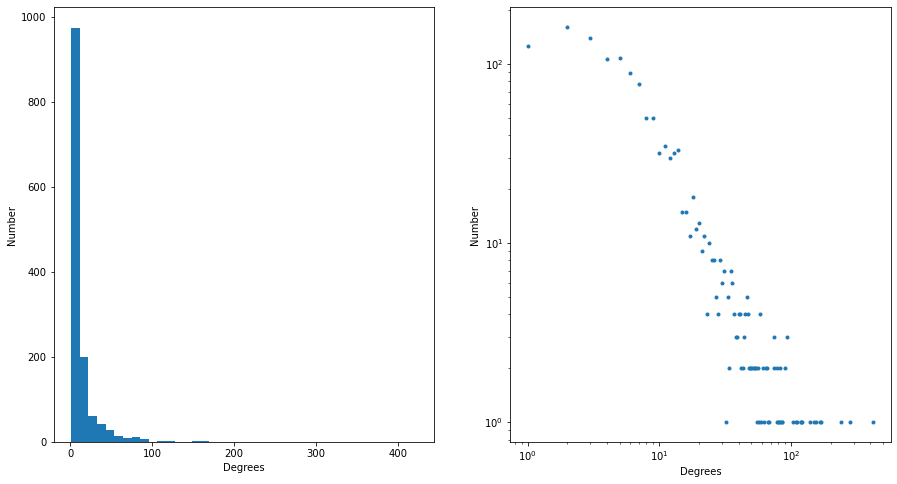

In [32]:
import matplotlib.pyplot as plt
import numpy as np

degrees_dictionary = dict(G_all.degree())
degrees = np.array(list(dict(G_all.degree()).values()))

# show node degrees
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

axs[0].set_xlabel('Degrees')
axs[0].set_ylabel('Number')
axs[0].hist(degrees, 40)

from collections import Counter

d = Counter(degrees)

axs[1].set_xlabel('Degrees')
axs[1].set_ylabel('Number')
axs[1].loglog(list(d.keys()), list(d.values()), '.', lw=2)

plt.show()

Small world

Distances distribution

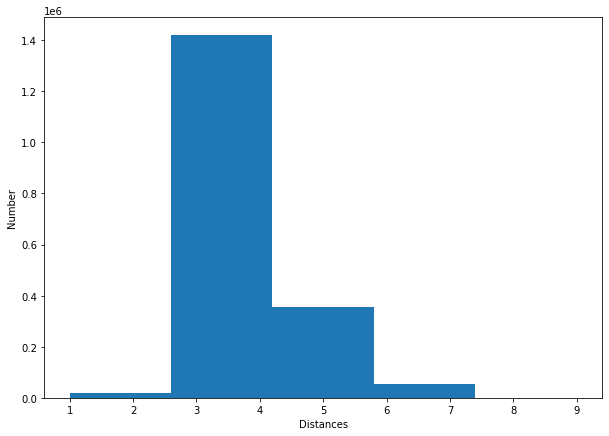

In [119]:
shortest_paths = nx.shortest_path(G_all)
lengths = []
for target, paths in shortest_paths.items():
    for k, value in paths.items():
        lengths.append(len(value))

fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(lengths, 5)
ax.set_xlabel('Distances')
ax.set_ylabel('Number')

plt.show()

In [35]:
print('Average clustering coefficient:', nx.average_clustering(G_all))
print('Global clustering coefficient: ', nx.transitivity(G_all))

Average clustering coefficient: 0.6693551748893263
Global clustering coefficient:  0.21474754081863695


The degree distribution meets the feature of power law distribution.  
The average distance is small.  
However, the global clustering coefficient is very samll. The reason is that, as a historiacal novel, Romance of the three kingdoms includes many real historical events and figures which actually have no attributions to the main story.

### Visualizing the whole network

There are some many nodes and edges in this graph. We have to select the most nodes better visualization.

In [41]:
G_all_main = nx.k_core(G_all, k=20).copy()
G_all_main.number_of_nodes()

119

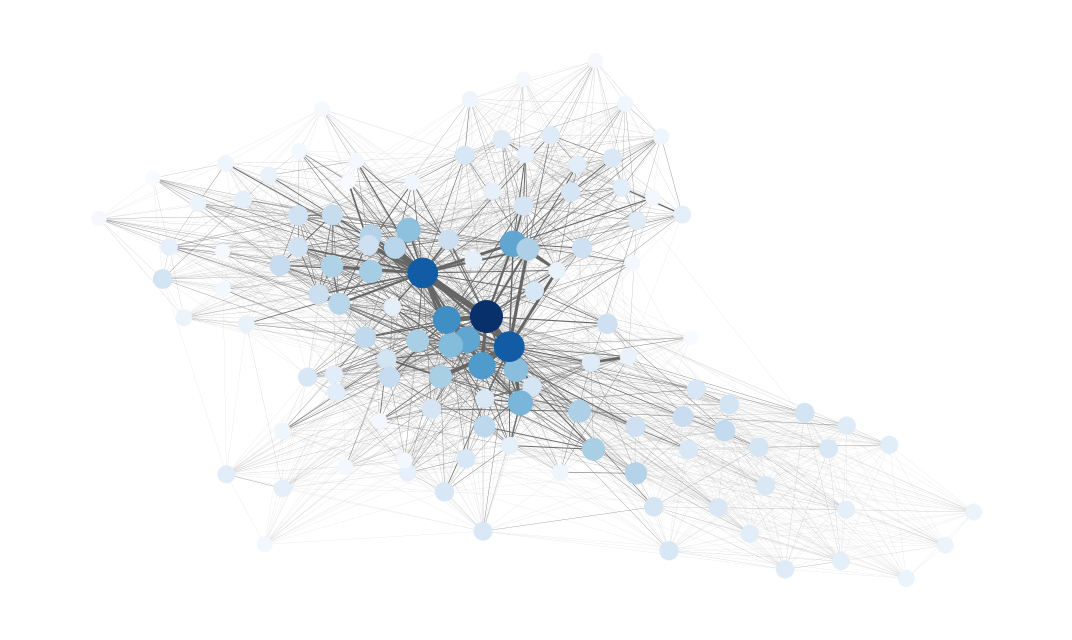

In [59]:
# Draw graph with varying node color, node size, and edge width
fig, ax = plt.subplots(figsize=(15, 9))

node_color = [2*G_all_main.degree(v) for v in G_all_main] #根据节点度上色
node_size = [10*G_all_main.degree(v) for v in G_all_main] #根据节点度调大小
edge_width = [0.05*G_all_main[u][v]['weight'] for u,v in G_all_main.edges()] #根据边的权重调粗细
pos = nx.spring_layout(G_all_main)
nx.draw_networkx(G_all_main, pos, 
                 node_color=node_color, 
                 node_size=node_size, 
                 alpha=1, with_labels=False, 
                 width=edge_width, edge_color='.4', cmap=plt.cm.Blues)
ax.axis('off')
fig.tight_layout()

### Rankings by centralities

Rank all characters by different node centralities, and then visualize the top 20.

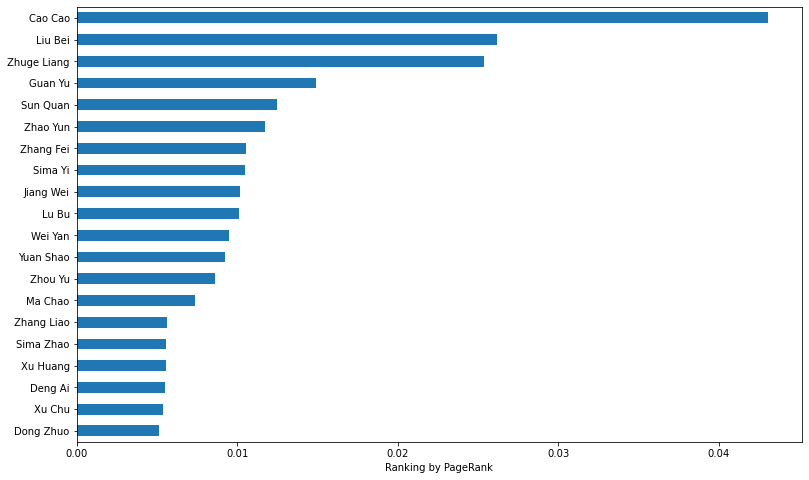

In [74]:
# Ranking by pagerank
import pandas as pd
     
fig, ax = plt.subplots(figsize=(13,8))
between = pd.Series(nx.pagerank(G_all)).sort_values()
between.tail(20).plot(kind="barh")
ax.set_xlabel('Ranking by PageRank')
plt.show()

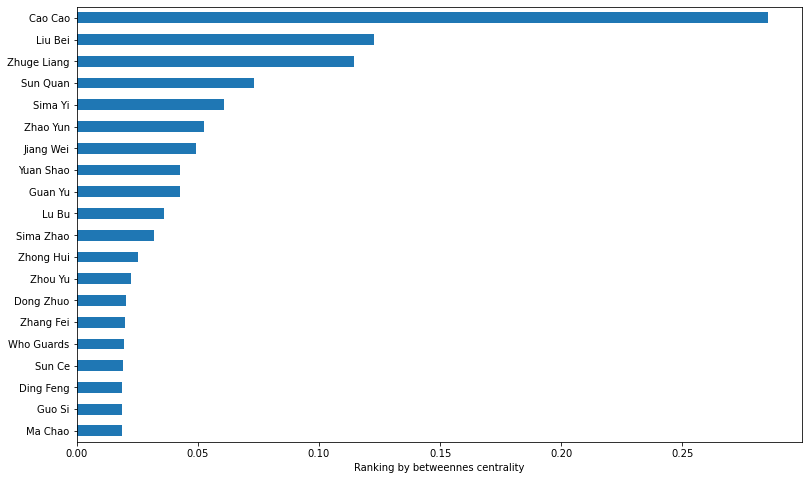

In [75]:
# Ranking by betweennes centrality

fig, ax = plt.subplots(figsize=(13,8))
between = pd.Series(nx.betweenness_centrality(G_all)).sort_values()
between.tail(20).plot(kind="barh")
ax.set_xlabel('Ranking by betweennes centrality')
plt.show()

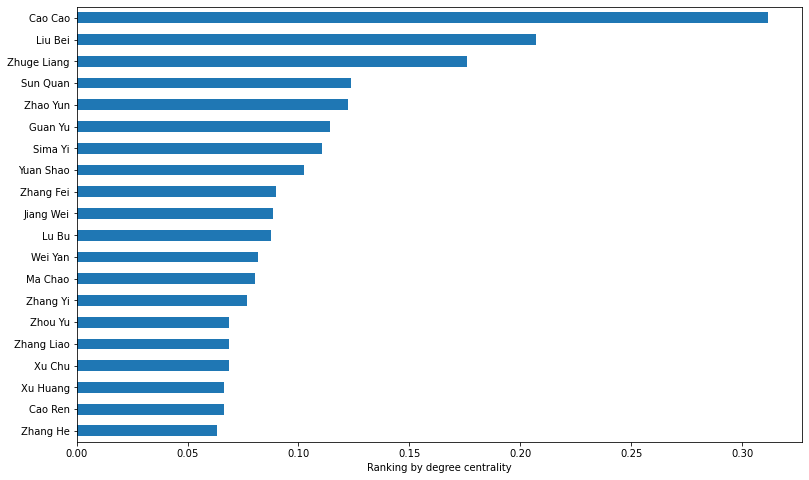

In [76]:
#Ranking by degree centrality

fig, ax = plt.subplots(figsize=(13,8))
between = pd.Series(nx.degree_centrality(G_all)).sort_values()
between.tail(20).plot(kind="barh")
ax.set_xlabel('Ranking by degree centrality')
plt.show()

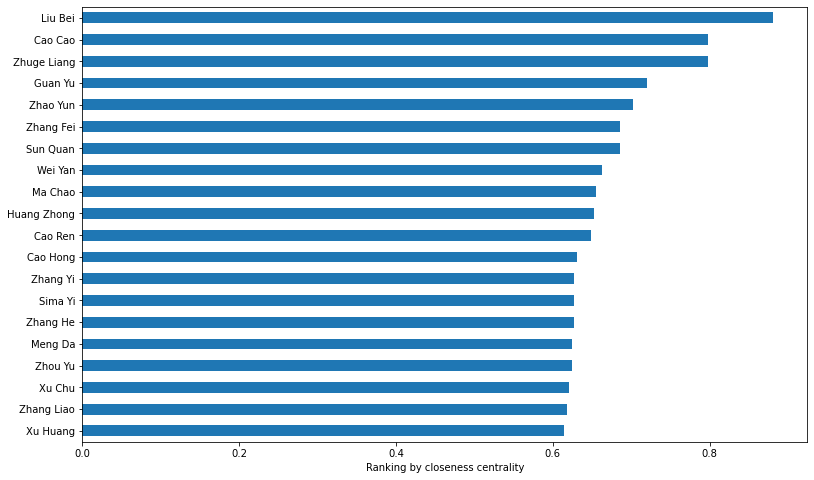

In [77]:
#Ranking by closeness centrality

fig, ax = plt.subplots(figsize=(13,8))
between = pd.Series(nx.closeness_centrality(G_all_main)).sort_values()
between.tail(20).plot(kind="barh")
ax.set_xlabel('Ranking by closeness centrality')
plt.show()

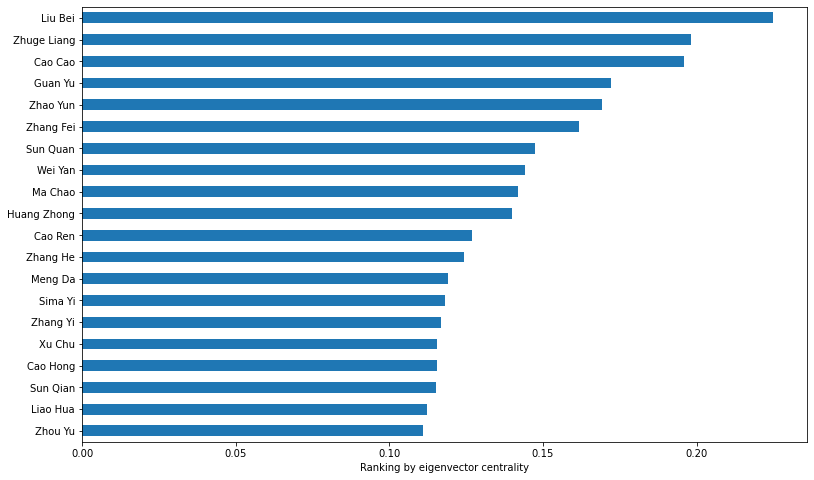

In [78]:
#Ranking by eigenvector centrality

fig, ax = plt.subplots(figsize=(13,8))
between = pd.Series(nx.eigenvector_centrality(G_all_main)).sort_values()
between.tail(20).plot(kind="barh")
ax.set_xlabel('Ranking by eigenvector centrality')
plt.show()

Nodes with high eigenvector centrality always cluster together. In the ranking by eigenvector centrality, characters from Kingdom Shu have high rating, which means that there are actually many main characters from Kingdom Shu.

In all rankings, the characters from Kingdom Wu occupied relatively few positions, and their ratings are really low, which means that the author actually spent less words on Kingdom Wu. The main characters are from Kingdom Wei and Kingdom Shu.

### Bridges

In [70]:
nx.has_bridges(G_all_main)

False